In [33]:
################################
# Scientific imports
################################
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astroquery.mast import Observations
from astroquery.mast import Catalogs
from astropy import units as u
from astropy.timeseries import BoxLeastSquares
from astropy.timeseries import TimeSeries

###
# General imports
###
import csv, math, io, os, os.path, sys, random, time
import pandas as pd
import seaborn as sb
from tqdm.notebook import tqdm, trange

###
# SciKitLearn Imports
###
import sklearn
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

from IPython.display import display

################################
# MatPlotLib Settings
################################
plt.rcParams["figure.figsize"] = (20,9)
sb.set()

################################
# Suppress Warnings
################################
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

################################
# Initialisers
################################

# Load the Data files
fitsarr = np.load("fitslist.npy")
foldedfluxarr = np.load("foldedflux.npy")
fluxarr = np.load("fluxlist.npy")
#planetarr = np.load("planetlist.npy")
#isplanetarr = np.load("isplanetlist.npy")

In [2]:
def DrawLC(rndFile=-1):
    
    # rndFile is random, unless specified
    rndFile = random.randint(0,len(fitsarr)) if rndFile==-1 else rndFile
    
    # Get LC data from the requisite fits file
    fitsFile = fitsarr[rndFile]

    # The following line of code gives us the header values
    fitsHeaders = fits.getheader(fitsFile)

    with fits.open(fitsFile, mode="readonly") as hdulist:

        # Extract stellar parameters from the primary header.  We'll get the effective temperature, surface gravity,
        # and TESS magnitude.
        star_teff = hdulist[0].header['TEFF']
        star_logg = hdulist[0].header['LOGG']
        star_tmag = hdulist[0].header['TESSMAG']
        obj       = hdulist[0].header['OBJECT']
        sector    = hdulist[0].header['SECTOR']


        # Extract some of the columns of interest for the first TCE signal.  These are stored in the binary FITS table
        # in the first extension.  We'll extract the timestamps in TBJD, phase, initial fluxes, and corresponding
        # model fluxes.
        tess_bjds     = hdulist[1].data['TIME']
        sap_fluxes    = hdulist[1].data['SAP_FLUX']
        pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']

    # X- and Y- labels
    #ylab = "PDCSAP Flux (e-/s)"
    ylab = "SAP Flux (e-/s)"
    xlab = "Time (TBJD)"

                        # pdcsap_fluxes[1:-1]
    return (tess_bjds[1:-1], sap_fluxes[1:-1], str(rndFile), str(obj), str(sector), ylab, xlab)

Text(0, 0.5, 'SAP Flux (e-/s)')

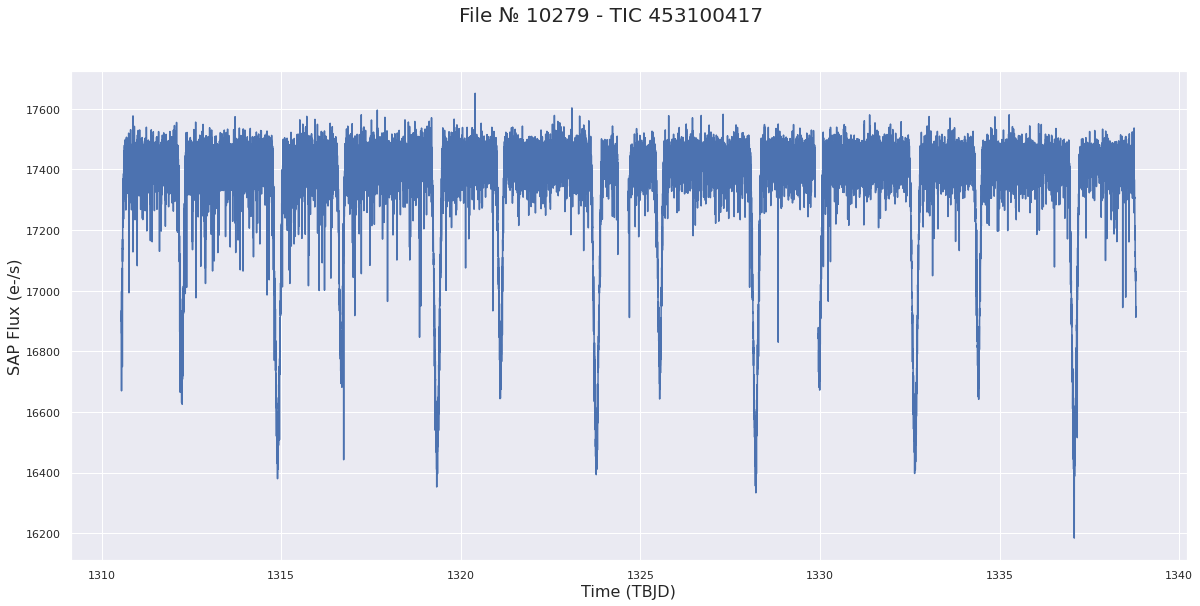

In [3]:
x,y,f,o,s,ylab,xlab = DrawLC(10279)

fig, ax = plt.subplots()
ax.plot(x,y)
fig.suptitle("File № {} - {}".format(f, o), fontsize=20) # + str(obj) + " - Sector " + str(sector))
ax.set_xlabel(xlab, fontsize=16)
ax.set_ylabel(ylab, fontsize=16)

Text(0, 0.5, 'SAP Flux (e-/s)')

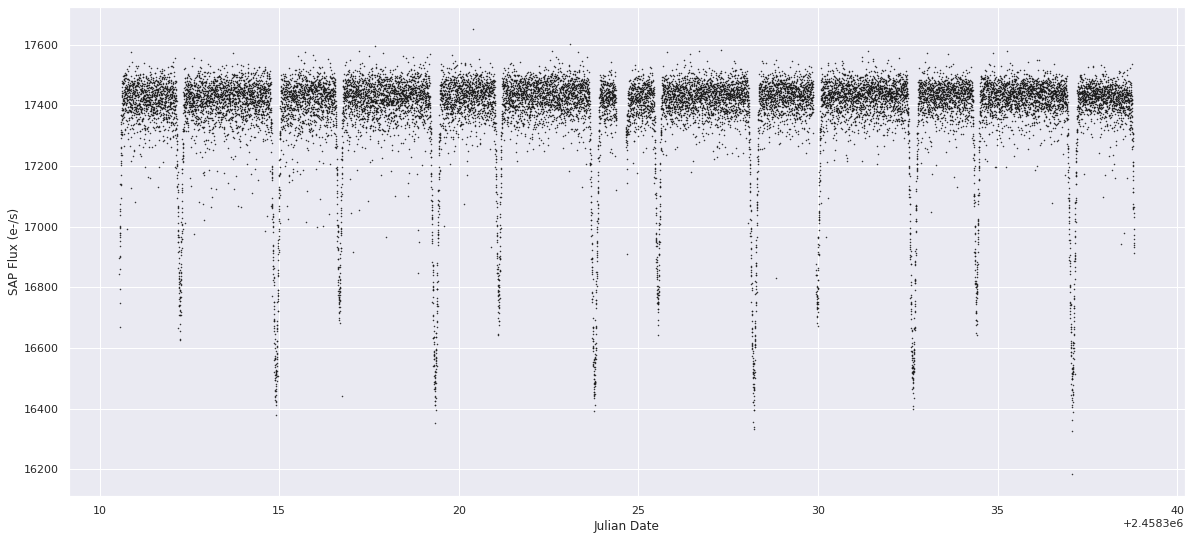

In [3]:
f = 10279

ts = TimeSeries.read(fitsarr[int(f)], format='tess.fits')
periodogram = BoxLeastSquares.from_timeseries(ts, 'sap_flux')

plt.plot(ts.time.jd, ts['sap_flux'], 'k.', markersize=1)
plt.xlabel('Julian Date')
plt.ylabel('SAP Flux (e-/s)')

In [4]:
results = periodogram.autopower(0.2 * u.day)  
best = np.argmax(results.power)  
period = results.period[best]  
period

<Quantity 4.44066217 d>

In [5]:
transit_time = results.transit_time[best]  
transit_time

<Time object: scale='tdb' format='isot' value=2018-07-15T09:22:42.917>

In [6]:
ts_folded = ts.fold(period=period, epoch_time=transit_time)

Text(0, 0.5, 'SAP Flux (e-/s)')

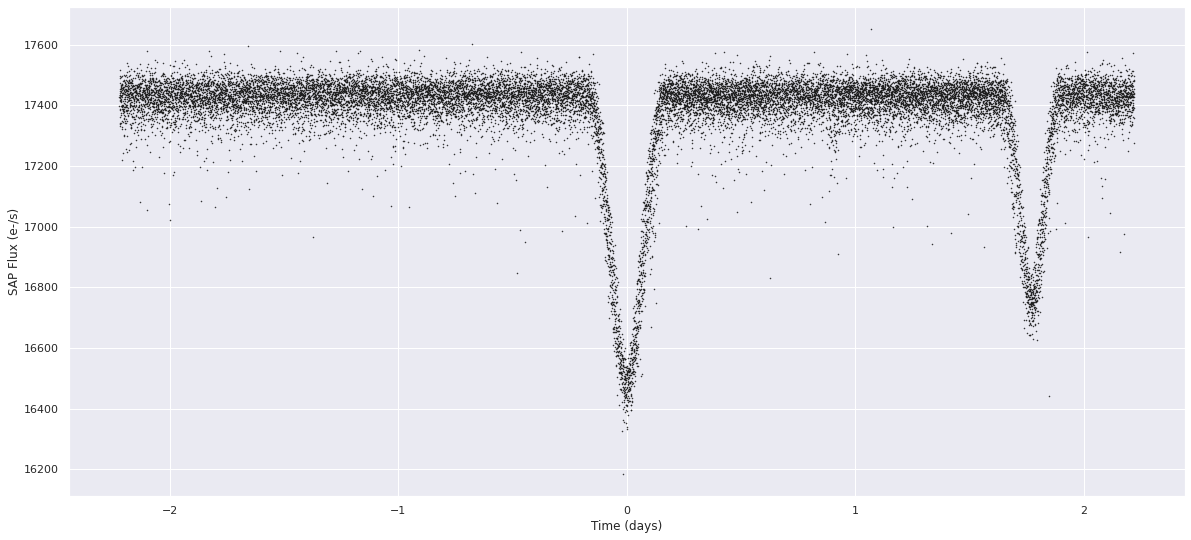

In [7]:
plt.plot(ts_folded.time.jd, ts_folded['sap_flux'], 'k.', markersize=1)
plt.xlabel('Time (days)')
plt.ylabel('SAP Flux (e-/s)')

/home/jdowzell/anaconda3/lib/python3.8/site-packages/astropy/timeseries/downsample.py:28: RuntimeWarning: Mean of empty slice
  result.append(function(array[indices[i]:indices[i+1]]))
/home/jdowzell/anaconda3/lib/python3.8/site-packages/astropy/timeseries/downsample.py:29: RuntimeWarning: Mean of empty slice
  result.append(function(array[indices[-1]:]))


Text(0, 0.5, 'Normalized flux')

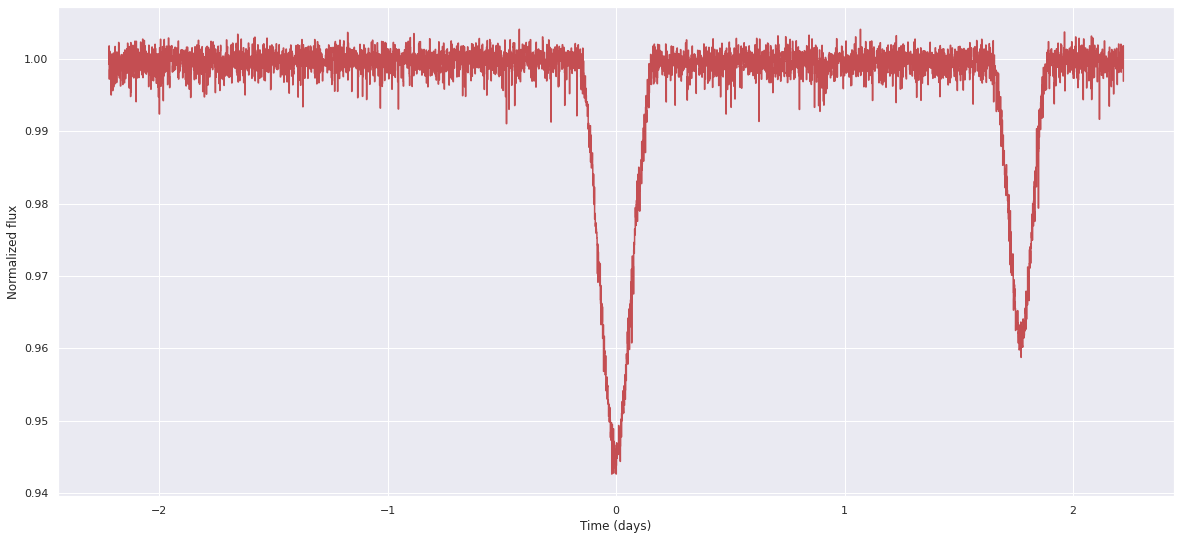

In [8]:
from astropy.stats import sigma_clipped_stats
from astropy.timeseries import aggregate_downsample

mean, median, stddev = sigma_clipped_stats(ts_folded['sap_flux'])  
ts_folded['sap_flux_norm'] = ts_folded['sap_flux'] / median

ts_binned = aggregate_downsample(ts_folded, time_bin_size=0.001 * u.day)  
ts_binned  

#plt.plot(ts_folded.time.jd, ts_folded['sap_flux_norm'], 'k.', markersize=1)
plt.plot(ts_binned.time_bin_start.jd, ts_binned['sap_flux_norm'], 'r-', markersize=0.5, drawstyle='steps-post')
plt.xlabel('Time (days)')
plt.ylabel('Normalized flux')

In [9]:
len(ts_folded['sap_flux'])

20081

In [10]:
len(ts_binned['sap_flux_norm'])

4441

In [12]:
foldedflux = list(ts_folded['sap_flux'].value)
foldedflux[:10]

[16844.664,
 16897.707,
 16934.693,
 16669.404,
 16997.668,
 16858.96,
 16902.396,
 16995.416,
 16898.367,
 17039.045]

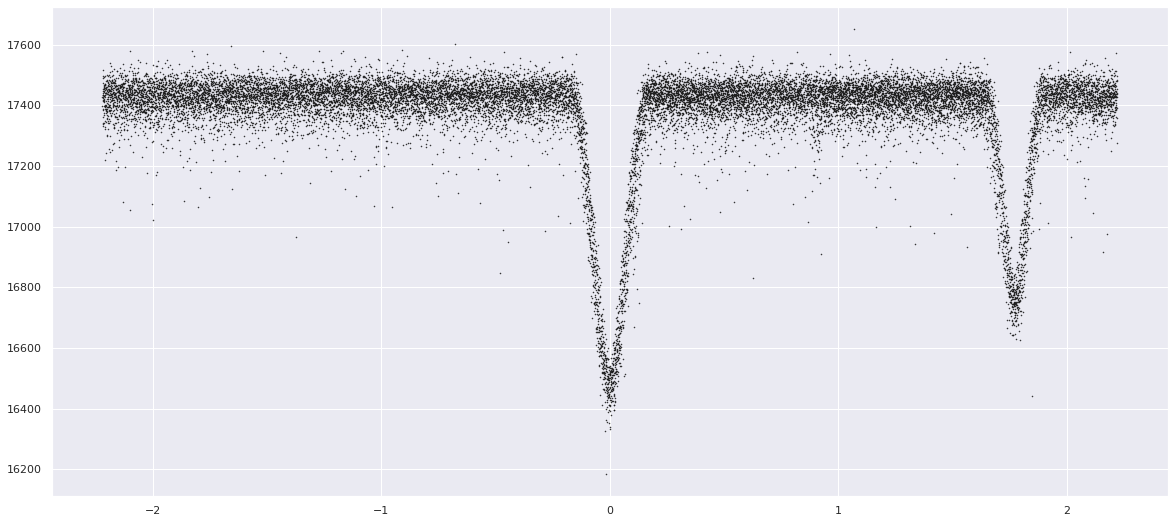

In [13]:
plt.plot(ts_folded.time.jd, foldedflux, 'k.', markersize=1)
#plt.plot(foldedflux, 'k.', markersize=1)

(1500.0, 1550.0)

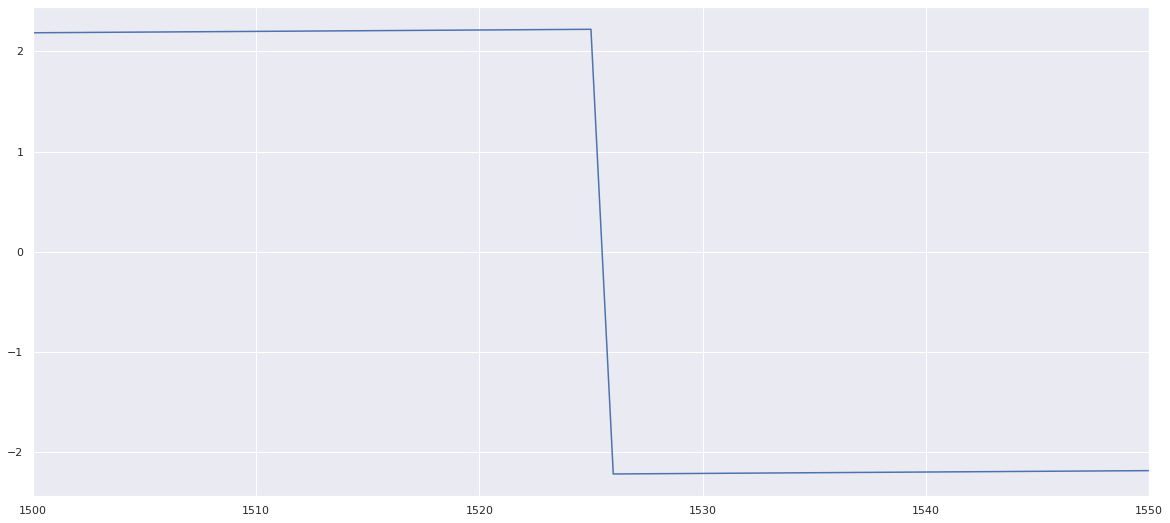

In [14]:
plt.plot(ts_folded.time.jd)
plt.xlim([1500,1550])

In [13]:
ts_folded.time.jd[1500:1550]

array([ 2.185348  ,  2.18673687,  2.18812574,  2.1895146 ,  2.19090347,
        2.19229234,  2.1936812 ,  2.19507007,  2.19645894,  2.19784781,
        2.19923667,  2.20062554,  2.20201441,  2.20340327,  2.20479214,
        2.20618101,  2.20756988,  2.20895874,  2.21034761,  2.21173648,
        2.21312534,  2.21451421,  2.21590308,  2.21729195,  2.21868081,
        2.22006968, -2.21920362, -2.21781475, -2.21642588, -2.21503702,
       -2.21364815, -2.21225928, -2.21087041, -2.20948155, -2.20809268,
       -2.20670381, -2.20531495, -2.20392608, -2.20253721, -2.20114834,
       -2.19975948, -2.19837061, -2.19698174, -2.19559288, -2.19420401,
       -2.19281514, -2.19142627, -2.19003741, -2.18864854, -2.18725967])

In [15]:
max(ts_folded.time.jd) - min(ts_folded.time.jd)

4.440191636114832

# need to find a way to take the folded data and make it linear across the x axis, instead of it being from -N >= x > N
## (i.e.: from 0 >= x > 2N)

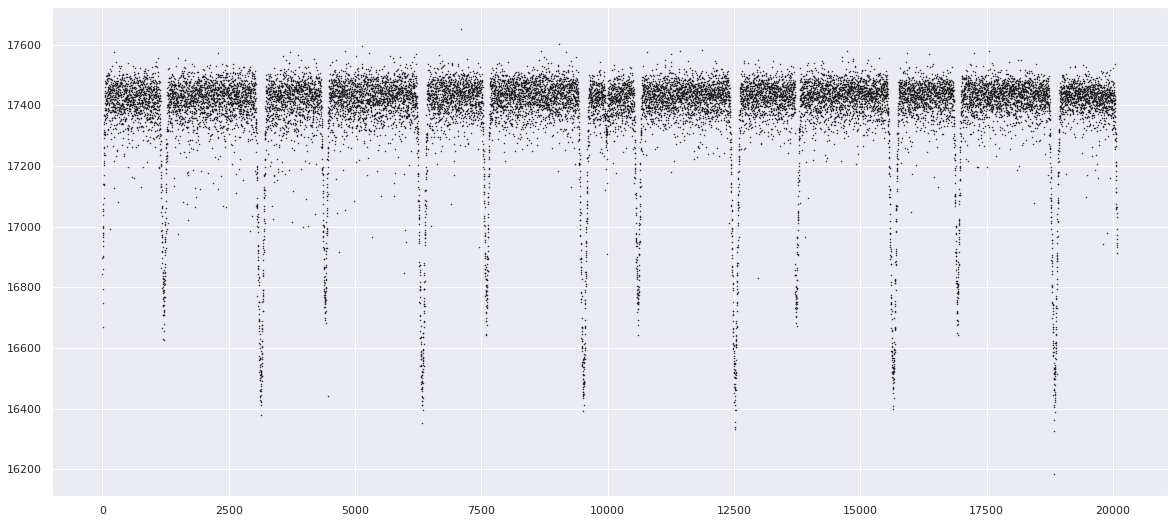

In [16]:
plt.plot(foldedflux, 'k.', markersize=1)

In [16]:
unfoldedtime = [0] * len(ts_folded.time.jd)

for i in range(len(ts_folded.time.jd)):
    unfoldedtime[i] = [ts_folded.time.jd[i],i]

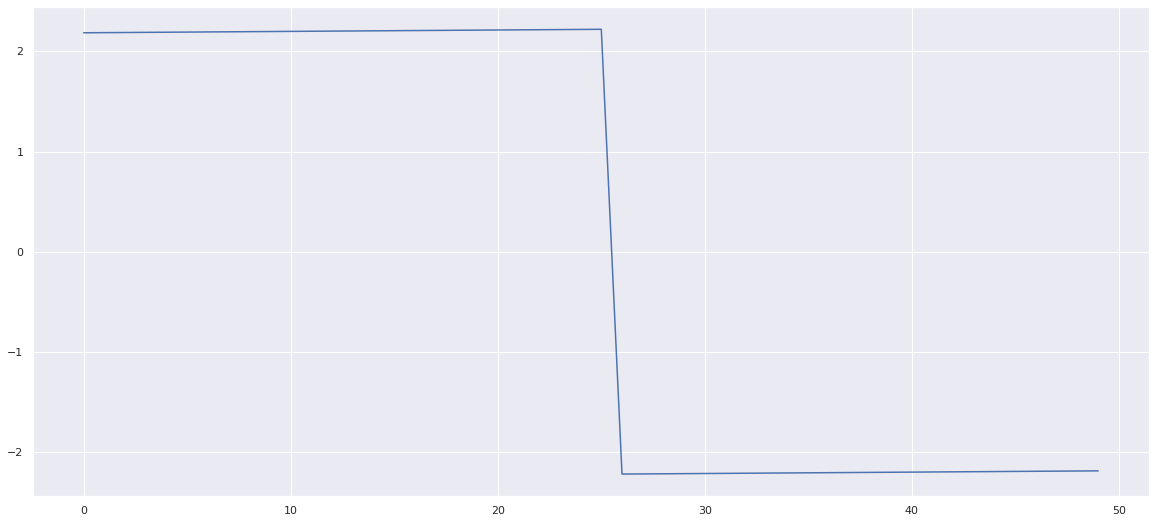

In [17]:
plt.plot(ts_folded.time.jd[1500:1550])

In [18]:
G = []
Q = list(ts_folded.time.jd.copy())

for i,e in enumerate(Q):
    G.append({'index': i, 'time': e, 'flux': foldedflux[i]})
#G[:25]

In [19]:
newlist = sorted(G, key=lambda k: k['time']) 
#newlist = newlist[::2]
#newlist[:25]

In [20]:
len(newlist)

20081

In [21]:
FLATFLUX = [d['flux'] for d in newlist]

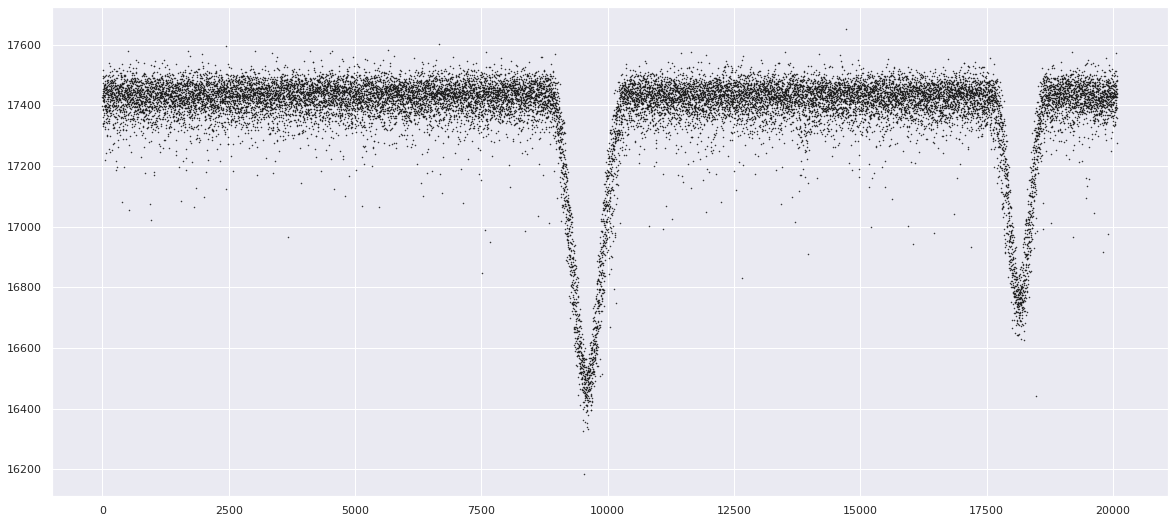

In [22]:
plt.plot(FLATFLUX, 'k.', markersize=1)

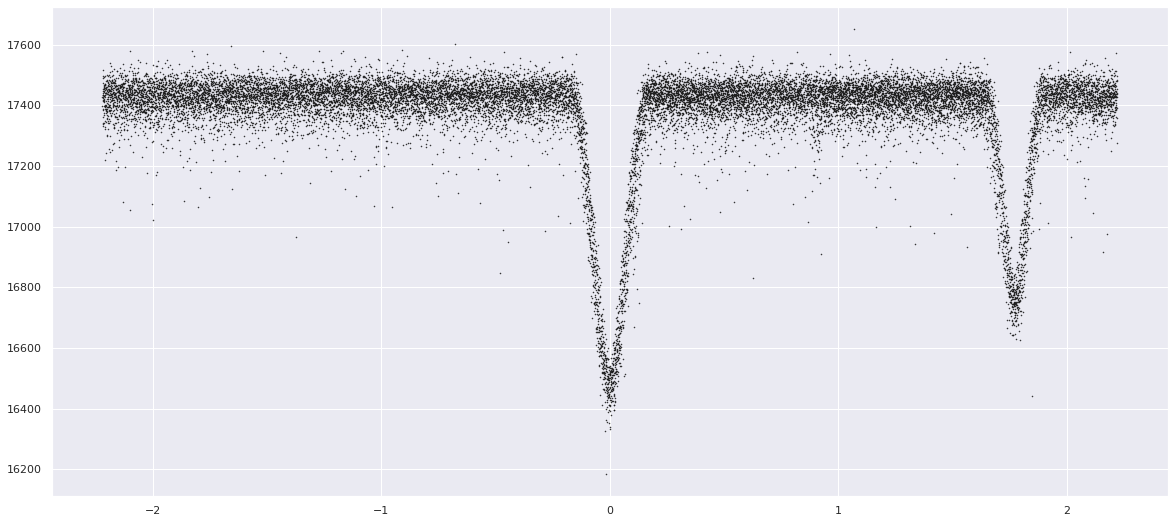

In [23]:
plt.plot(ts_folded.time.jd, foldedflux, 'k.', markersize=1)

In [15]:
from astropy.timeseries import aggregate_downsample
ts_binned = aggregate_downsample(ts_folded, time_bin_size=0.03 * u.day)  
#ts_binned 

/home/jdowzell/anaconda3/lib/python3.8/site-packages/astropy/timeseries/downsample.py:28: RuntimeWarning: Mean of empty slice
  result.append(function(array[indices[i]:indices[i+1]]))
/home/jdowzell/anaconda3/lib/python3.8/site-packages/astropy/timeseries/downsample.py:29: RuntimeWarning: Mean of empty slice
  result.append(function(array[indices[-1]:]))


149


array([17416.01367188, 17423.44921875, 17416.12304688, 17418.86132812,
       17426.46875   , 17424.68945312, 17416.65820312, 17413.25390625,
       17424.39257812, 17428.95703125, 17422.20898438, 17416.66210938,
       17420.17382812, 17418.89453125, 17422.05859375, 17426.62695312,
       17414.88476562, 17422.37304688, 17427.15429688, 17420.23632812,
       17424.16992188, 17427.03320312, 17426.41796875, 17427.0078125 ,
       17428.18554688, 17420.12109375, 17417.01953125, 17427.10742188,
       17429.0703125 , 17429.85351562, 17423.88671875, 17422.01171875,
       17426.02929688, 17430.52734375, 17427.21875   , 17430.31445312,
       17425.55859375, 17420.78710938, 17423.31640625, 17413.2578125 ,
       17428.28515625, 17424.05859375, 17420.09570312, 17432.61523438,
       17424.96875   , 17429.6171875 , 17416.30078125, 17421.82617188,
       17423.7421875 , 17423.06054688])

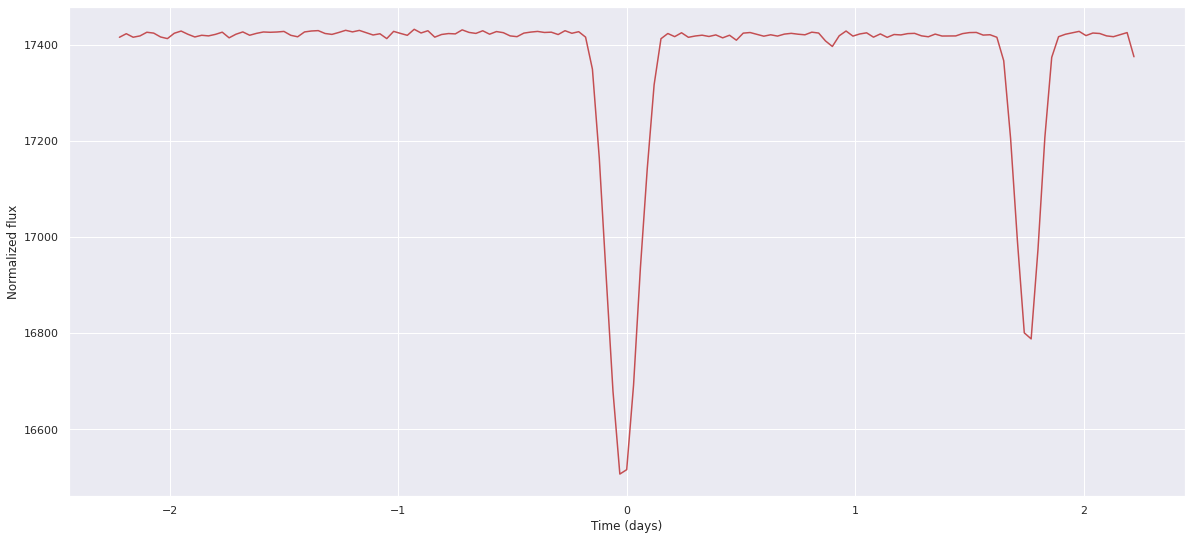

In [56]:
#plt.plot(ts_folded.time.jd, ts_folded['sap_flux'], 'k.', markersize=1)
plt.plot(ts_binned.time_bin_start.jd, ts_binned['sap_flux'], 'r-') #, drawstyle='steps-post')
plt.xlabel('Time (days)')
plt.ylabel('Normalized flux')
print(len(ts_binned['sap_flux']))
ts_binned['sap_flux'].value[0:50]

In [17]:
def FoldTheFlux(f):
    ts = TimeSeries.read(fitsarr[int(f)], format='tess.fits')  
    periodogram = BoxLeastSquares.from_timeseries(ts, 'sap_flux')
    results = periodogram.autopower(0.2 * u.day)  
    best = np.argmax(results.power)  
    period = results.period[best]
    transit_time = results.transit_time[best]
    ts_folded = ts.fold(period=period, epoch_time=transit_time)
    foldedflux = list(ts_folded['sap_flux'].value)
    
    # UN-FOLD THE X AXIS SOMEHOW
    unfoldedtime = [0] * len(ts_folded.time.jd)

    for i in range(len(ts_folded.time.jd)):
        unfoldedtime[i] = [ts_folded.time.jd[i],i]
    
    G = []
    Q = list(ts_folded.time.jd.copy())

    for i,e in enumerate(Q):
        G.append({'index': i, 'time': e, 'flux': foldedflux[i]})
    
    newlist = sorted(G, key=lambda k: k['time'])
    
    FLATFLUX = [d['flux'] for d in newlist]
    
    return (FLATFLUX)

In [15]:
len(fitsarr)

16000

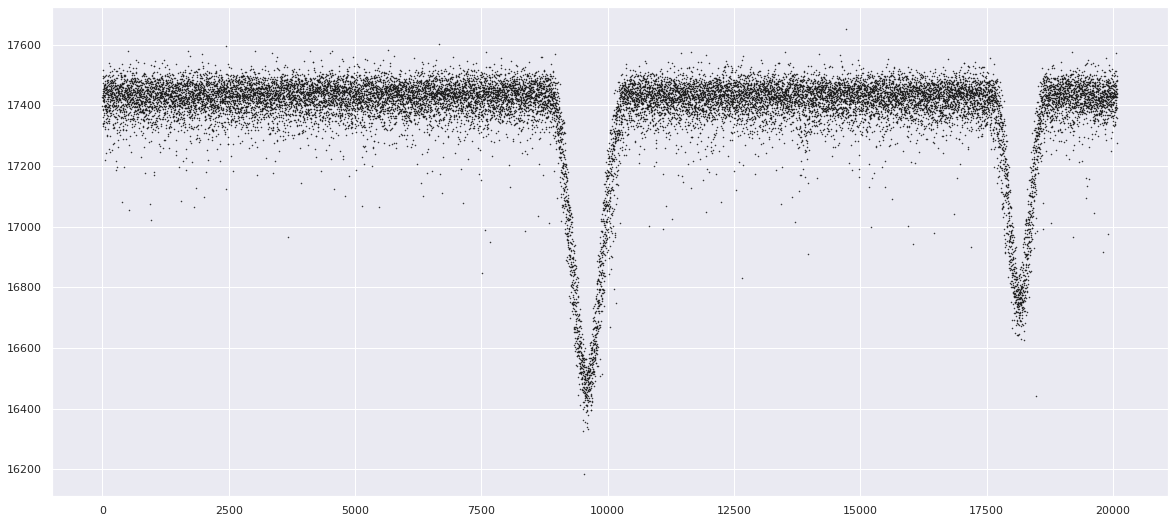

In [175]:
plt.plot(foldedfluxarr[f], 'k.', markersize=1)

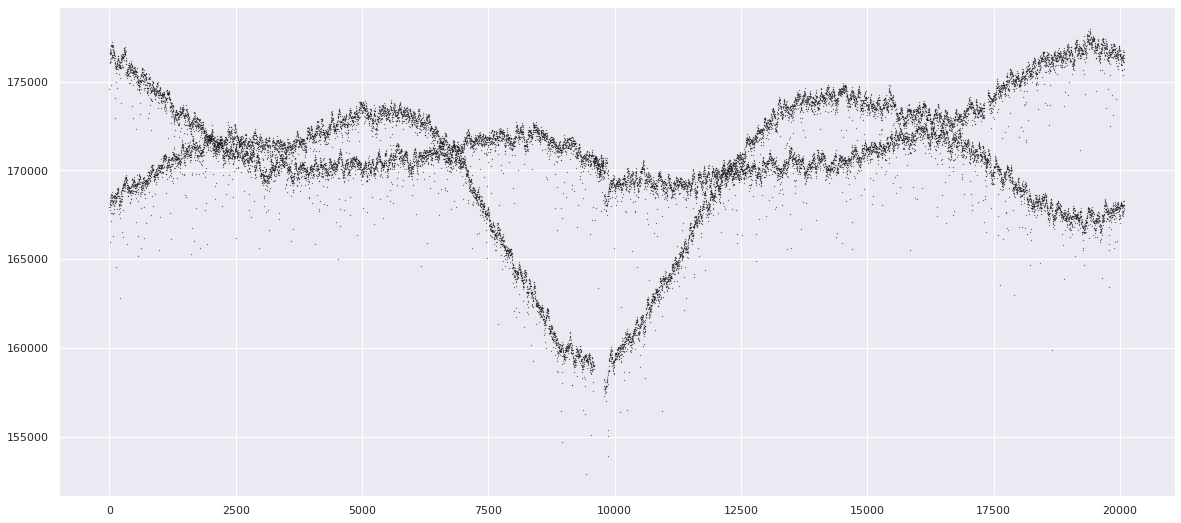

In [14]:
fFlux = np.load("foldedflux.npy")
Q = fFlux[0]
plt.plot(Q,'k.',markersize=0.5)

20081


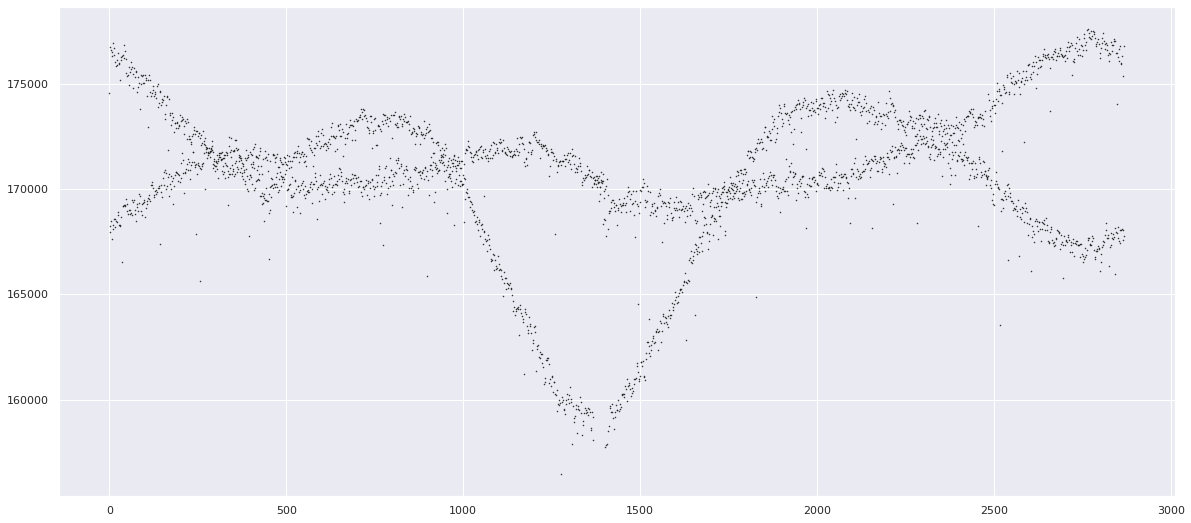

In [32]:
every_nth_sample = 7
print(len(Q))
plt.plot(Q[::every_nth_sample],'k.',markersize=1.0)

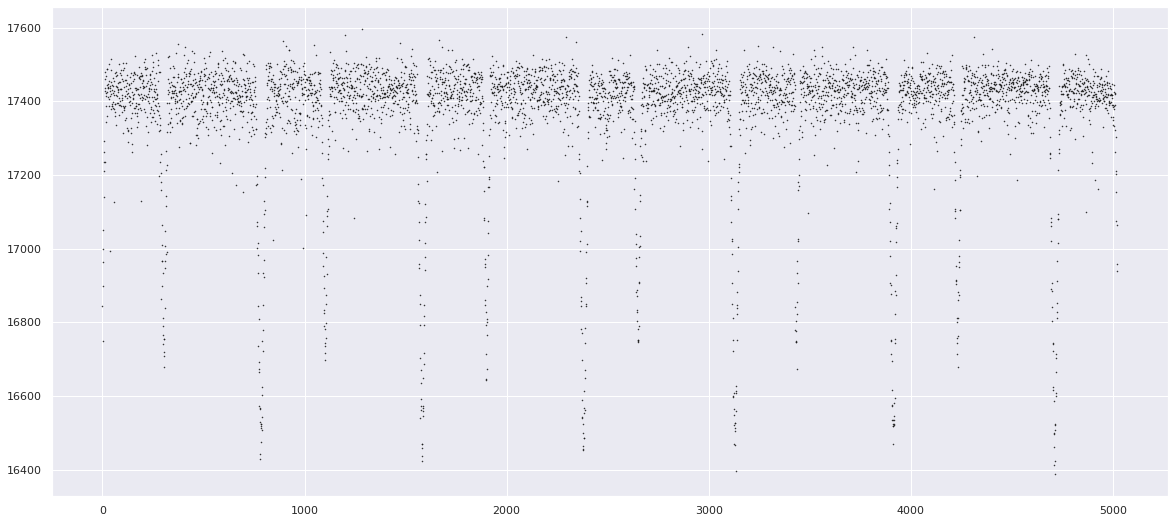

In [48]:
n=4
plt.plot(ts['sap_flux'][::n],'k.',markersize=1.0)

In [ ]:
################################################################################################################################################################

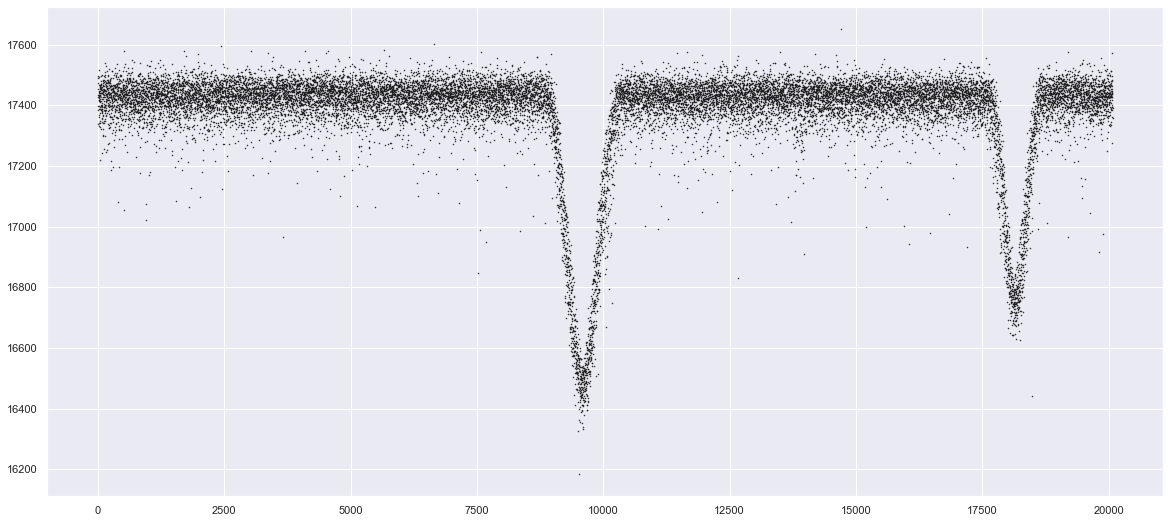

In [33]:
plt.plot(FoldTheFlux(f), 'k.', markersize=1)

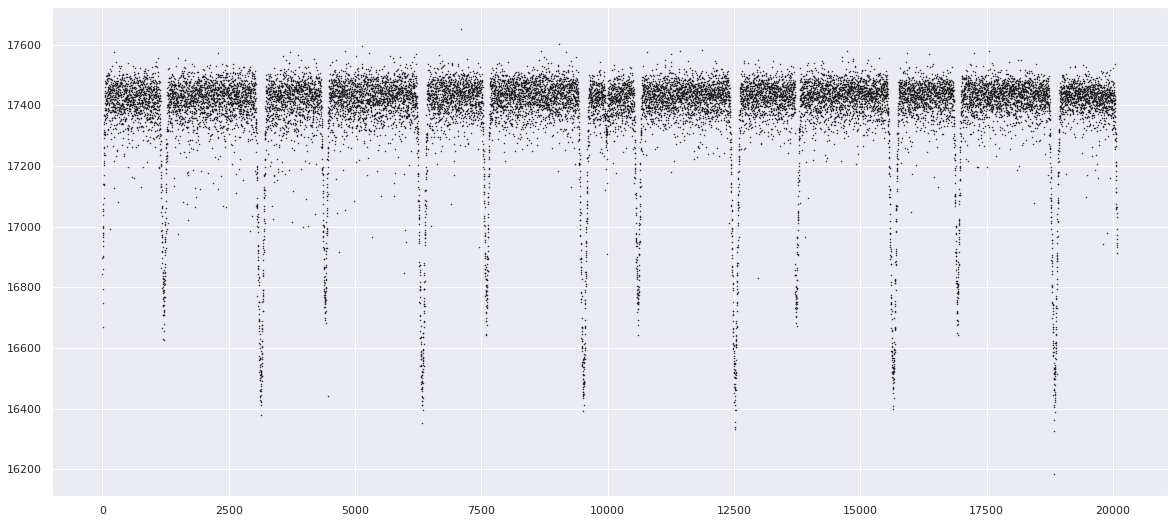

In [17]:
plt.plot(foldedflux, 'k.', markersize=1)

Text(0, 0.5, 'SAP Flux (e-/s)')

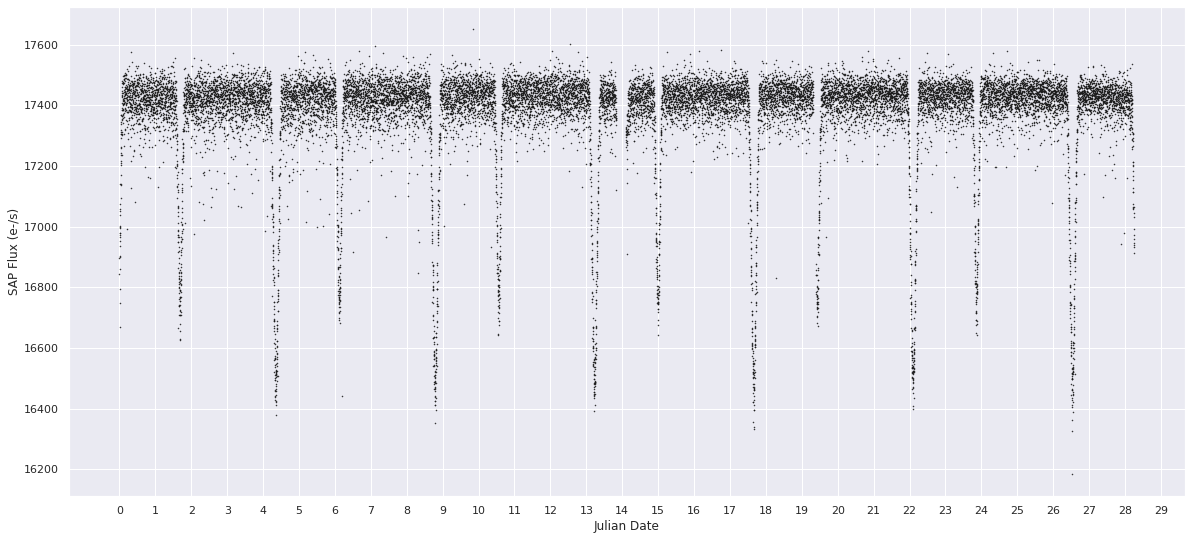

In [25]:
newXtime = (ts.time.jd[:] - min(ts.time.jd))
plt.plot(newXtime, ts['sap_flux'], 'k.', markersize=1)
plt.xticks(np.arange(min(newXtime), max(newXtime)+1, 1.0))
plt.xlabel('Julian Date')
plt.ylabel('SAP Flux (e-/s)')

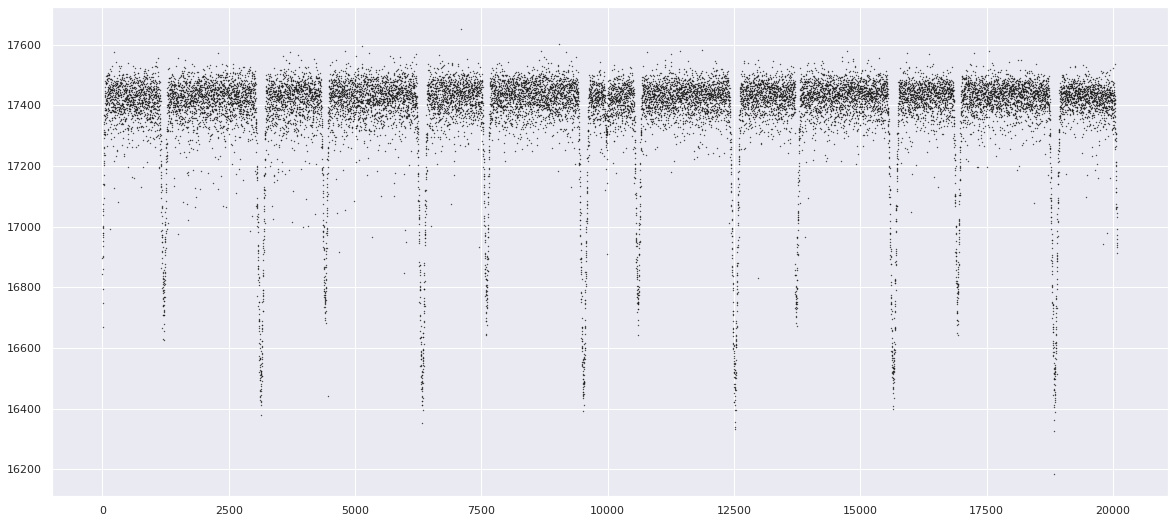

In [123]:
plt.plot(ts['sap_flux'], 'k.', markersize=0.75)

In [127]:
type(period.value)

numpy.float64

In [39]:
divider = 3
for i in tet:
    if i%divider==0:
        print("{} is divisible by {}!".format(i,divider))

3 is divisible by 3!
6 is divisible by 3!
9 is divisible by 3!
12 is divisible by 3!


In [185]:
tet = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12])
tet

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [186]:
tet[::3]

array([ 0,  3,  6,  9, 12])

In [182]:
for i in range(len(tet)):
    tet = np.delete(tet,[i+1:i+2])
tet

TypeError: _delete_dispatcher() missing 1 required positional argument: 'obj'

In [109]:
TET=tet.copy()
tetmax = max(TET)
while tetmax > divider:
    for i in TET:
        print(i)
        if i%divider==0 and i>0:
            print("array from point {} is: {}!".format(i,TET[i:]))
            #print("{} is divisible by {}".format(TET[i:],divider))
            TET[i:] = TET[i:] - divider
            tetmax = max(TET)

0
1
2
3
[ 3  4  5  6  7  8  9 10 11 12] is divisible by 3
1
2
3
[0 1 2 3 4 5 6 7 8 9] is divisible by 3
1
2
3
[-3 -2 -1  0  1  2  3  4  5  6] is divisible by 3
1
2
3
[-6 -5 -4 -3 -2 -1  0  1  2  3] is divisible by 3


In [110]:
TET

array([ 0,  1,  2, -9, -8, -7, -6, -5, -4, -3, -2, -1,  0])

In [116]:
TET = tet.copy()

for n,i in enumerate(TET):
    #print(i)
    if i%divider==0 and i>0:
        #print("array from point {} is: {}!".format(n,TET[n:]))
        TET[n:] = TET[n:] - divider
        
TET

array([0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0])

In [170]:
def FoldTimeseries(ts,period):
    try:
        period=period.value
    except:
        print("Please enter a valid separator!")
        return
    
    TS = ts[:].value
        
    for n,i in enumerate(TS):
        #print("{},{}".format(i,n))
        if i>=period and i>0:
            #print("array from point {} is: {}!".format(n,TET[n:]))
            TS[n:] = TS[n:] - period
    
    return(TS)

In [171]:
TS = ts['sap_flux'].copy()
TSS = FoldTimeseries(TS,period)

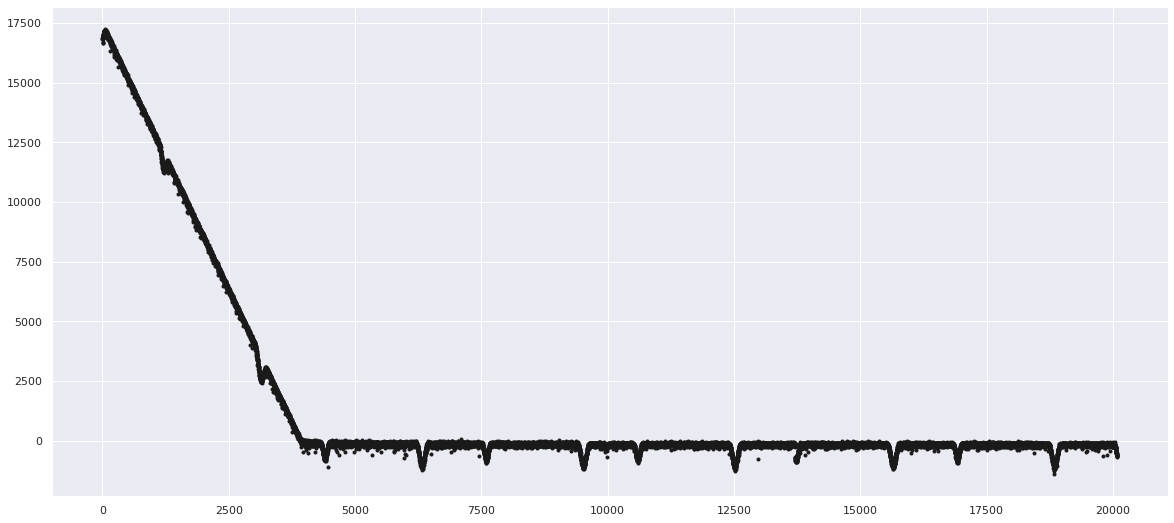

In [172]:
plt.plot(TSS,'k.')